# Lesson 7: sMRI Reproducibility Considerations

## Objectives
- Look at effects of pipeline selection on downstream analysis
    - Pipeline variations:
        - software: CIVET, FS6.0, FS5.3
        - QC: pass/fail (optional)

## Python Requirements
- [matplotlib](https://matplotlib.org/)
- [seaborn](https://seaborn.pydata.org/)

## Useful resources:
- [FreeSurfer cortical thickness estimation](https://surfer.nmr.mgh.harvard.edu/fswiki/FreeSurferAnalysisPipelineOverview#TheSurface-basedStream)
- [CIVET cortical thickness estimation](http://www.bic.mni.mcgill.ca/ServicesSoftware/CIVET-2-1-0-Table-of-Contents)
- [DKT atlas](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3514540/)

## Dataset used
- See [paper](https://academic.oup.com/gigascience/article/10/1/giaa155/6106556) and [repo](https://github.com/neurodatascience/compare-surf-tools) for details

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Local paths

In [2]:
local_data_dir = '../local_data/'
data_dir = local_data_dir +  "7_sMRI_reproducibility/"
data_csv = data_dir + 'ABIDE_CT_pipelines_DKT_software_QC.csv'


In [3]:
pipeline_data = pd.read_csv(data_csv, index_col=[0])

demograph_cols = ['SubjID','software','SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID','QC_pass']
roi_cols = list(set(pipeline_data.columns) - set(demograph_cols))
roi_cols.sort()

pipeline_data.head()

,SubjID,software,SEX,AGE_AT_SCAN,DX_GROUP,SITE_ID,QC_pass,L_caudalanteriorcingulate,L_caudalmiddlefrontal,L_cuneus,...,R_posteriorcingulate,R_precentral,R_precuneus,R_rostralanteriorcingulate,R_rostralmiddlefrontal,R_superiorfrontal,R_superiorparietal,R_superiortemporal,R_supramarginal,R_transversetemporal
0,50988,CIVET,0,14.21,1,NYU,True,2.3710,3.3758,2.5768,...,2.7521,3.1053,3.0872,2.4614,3.3433,3.3849,2.9059,3.2440,3.1223,3.0364
1,50349,CIVET,0,18.90,0,UM_1,True,3.6075,3.5244,3.2485,...,3.4099,3.2601,3.7179,3.8422,3.7154,3.9032,3.1536,3.7527,3.6728,3.5319
2,50402,CIVET,0,13.10,1,UM_2,True,3.3884,3.5692,3.0280,...,3.5040,3.2269,3.7348,3.4604,3.6145,3.7677,3.2595,3.4022,3.6111,3.4554
3,51265,CIVET,0,15.92,0,UCLA_1,True,2.5758,3.5407,3.0265,...,2.9843,3.2024,3.2458,2.7885,3.3654,3.4341,3.0785,3.4499,3.3577,3.1217
4,50199,CIVET,0,15.53,0,SDSU,True,2.8775,3.6949,3.0078,...,3.2349,3.4238,3.6915,3.5684,3.4913,3.7881,3.2489,4.0206,3.6317,3.7071


## Average thickness values per DKT ROI

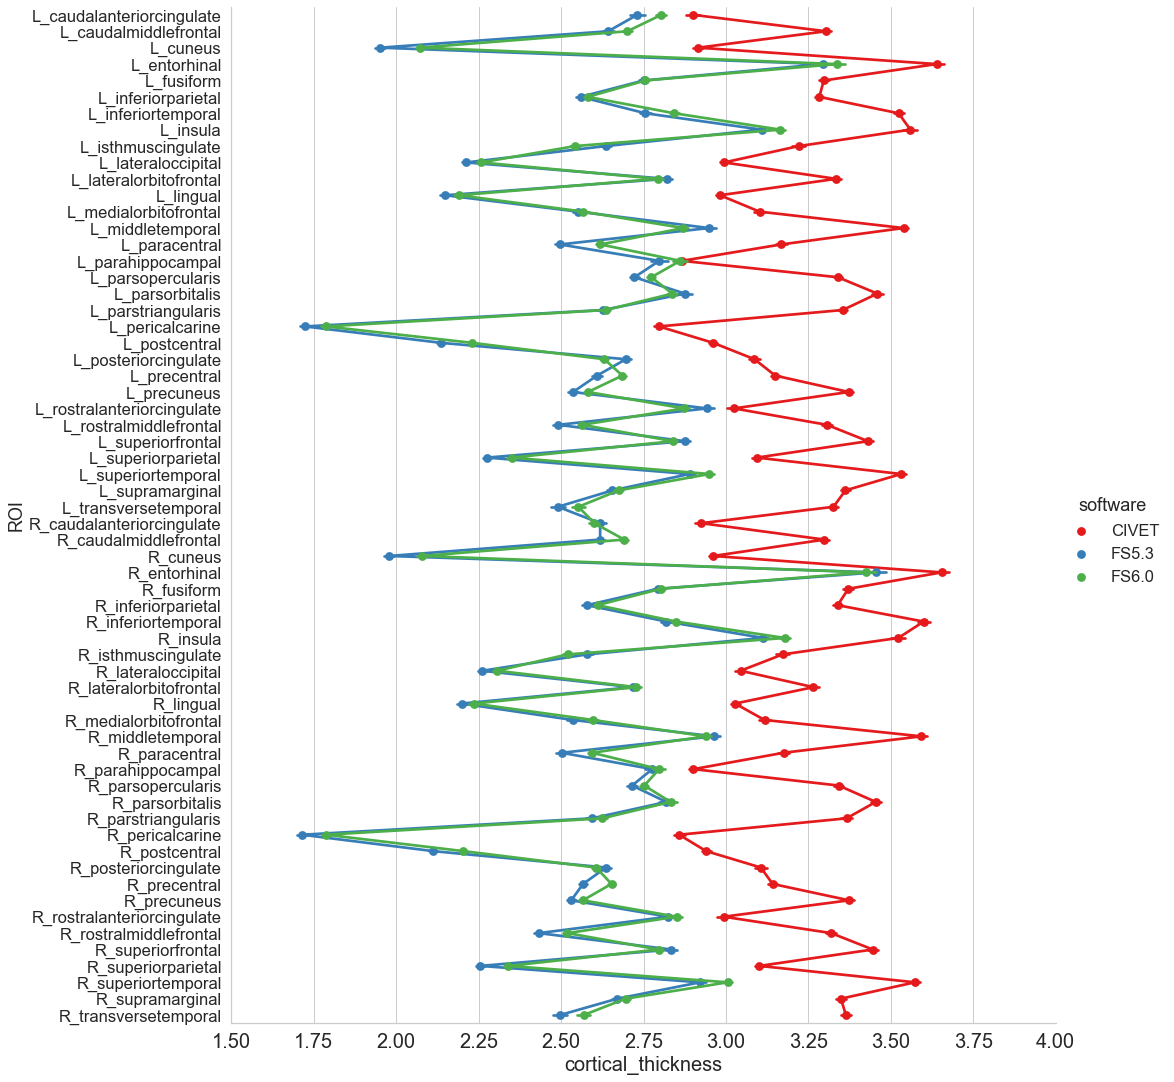

In [4]:
plot_df = pipeline_data.copy()
plot_df = pd.melt(plot_df, id_vars = demograph_cols, value_vars = roi_cols,
              var_name ='ROI', value_name ='cortical_thickness')

sns.set(font_scale=1.5)
palette = sns.color_palette('Set1')

with sns.axes_style("whitegrid"):
    g = sns.catplot(x='cortical_thickness',y='ROI',hue='software', height=15, aspect=1,
                    palette=palette, kind='point',data=plot_df)
    g.set_xticklabels(fontsize=20)
    g.set_xlabels(fontsize=20)
    

## Correlation between software per DKT ROI

### Pair 1 (between software)

In [5]:
sw1 = 'CIVET'
sw2 = 'FS6.0'

df1 = pipeline_data[pipeline_data['software'] == sw1].set_index('SubjID')[roi_cols]
df2 = pipeline_data[pipeline_data['software'] == sw2].set_index('SubjID')[roi_cols]

print('Number of subjects in df1: {}, df2: {}'.format(len(df1),len(df2)))

corr_df_pair1 = df1.corrwith(df2)
corr_df_pair1 = pd.DataFrame(corr_df_pair1.copy()).reset_index()
corr_df_pair1 = corr_df_pair1.rename(columns={'index':'ROI', 0:'correlation'})
corr_df_pair1['software_pair'] = '{}-{}'.format(sw1,sw2)

avg_corr_pair1 = np.mean(corr_df_pair1['correlation'])
print('\nAverage correlation between {} and {}: {:4.3f}'.format(sw1, sw2, avg_corr_pair1))
corr_df_pair1.head()

Number of subjects in df1: 779, df2: 779

Average correlation between CIVET and FS6.0: 0.520


,ROI,correlation,software_pair
0,L_caudalanteriorcingulate,0.321339,CIVET-FS6.0
1,L_caudalmiddlefrontal,0.661199,CIVET-FS6.0
2,L_cuneus,0.673254,CIVET-FS6.0
3,L_entorhinal,0.321045,CIVET-FS6.0
4,L_fusiform,0.459715,CIVET-FS6.0


### Pair 2 (between software versions)


In [6]:
sw1 = 'FS5.3'
sw2 = 'FS6.0'

df1 = pipeline_data[pipeline_data['software'] == sw1].set_index('SubjID')[roi_cols]
df2 = pipeline_data[pipeline_data['software'] == sw2].set_index('SubjID')[roi_cols]

print('Number of subjects in df1: {}, df2: {}'.format(len(df1),len(df2)))

corr_df_pair2 = df1.corrwith(df2)
corr_df_pair2 = pd.DataFrame(corr_df_pair2.copy()).reset_index()
corr_df_pair2 = corr_df_pair2.rename(columns={'index':'ROI', 0:'correlation'})
corr_df_pair2['software_pair'] = '{}-{}'.format(sw1,sw2)

avg_corr_pair2 = np.mean(corr_df_pair2['correlation'])
print('\nAverage correlation between {} and {}: {:4.3f}'.format(sw1, sw2, avg_corr_pair2))
corr_df_pair2.head()

Number of subjects in df1: 779, df2: 779

Average correlation between FS5.3 and FS6.0: 0.893


,ROI,correlation,software_pair
0,L_caudalanteriorcingulate,0.744499,FS5.3-FS6.0
1,L_caudalmiddlefrontal,0.931935,FS5.3-FS6.0
2,L_cuneus,0.919917,FS5.3-FS6.0
3,L_entorhinal,0.847039,FS5.3-FS6.0
4,L_fusiform,0.875062,FS5.3-FS6.0


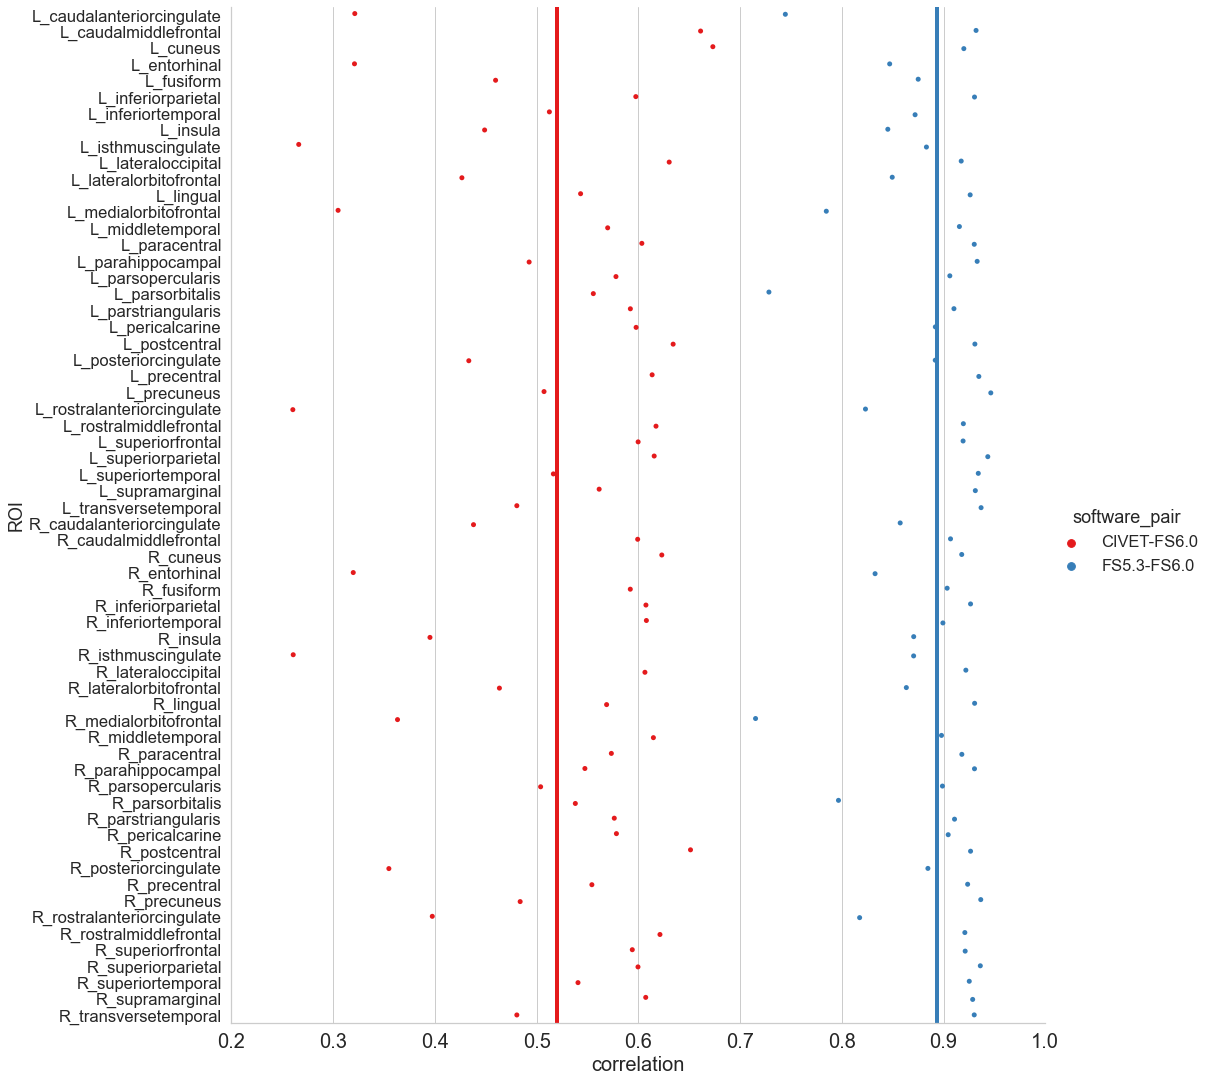

In [7]:
plot_df = corr_df_pair1.append(corr_df_pair2)

sns.set(font_scale=1.5)
palette = sns.color_palette('Set1')

with sns.axes_style("whitegrid"):
    g = sns.catplot(x='correlation',y='ROI', hue='software_pair',height=15, aspect=1,
                    palette=palette, kind='strip',data=plot_df)
    g.set_xticklabels(fontsize=20)
    g.set_xlabels(fontsize=20)

    plt.axvline(avg_corr_pair1,color=palette[0],linewidth=4)
    plt.axvline(avg_corr_pair2,color=palette[1],linewidth=4)
